In [821]:

import os
import csv
import math as m
import numpy as np
import matplotlib
matplotlib.use('Agg')
%matplotlib inline
import matplotlib.pyplot as plt


In [822]:

# STARTING VARIABLES
# orbits(years) -> revolutions(days) -> arcs(hours)
ORBITS_PER_SIMULATION   = 10 # years
REVOLUTIONS_PER_ORBIT   = 365 # days
ARCS_PER_REVOLUTION     = 24 # hours

# money to energy multiplier
# let's keep it equal (for now); make it easier to detect anomalies
# m2e = 6 # this is the lowest value before things are untenable
m2e = 1

# daily data points
X_revolutions       = list()
revolution_count    = 0
X_arcs              = list()
arc_count           = 0


In [823]:

class Me:

    # globals
    m2e = 0

    # current personal values
    energy  = 2000 # roughly equivalent to a traditional dietary calorie
    cash    = 2000

    # internal cash/energy level record
    energy_level    = list()
    cash_level      = list()


    # snapshot records
    earnings      = list()
    expenses      = list()
    consumption   = list()
    expenditure   = list()
    production    = list()

    # cumulative tally
    cum_earnings    = 0
    cum_expenses    = 0
    cum_consumption = 0
    cum_expenditure = 0
    cum_production  = 0

    # aggregated records
    agg_earnings    = list()
    agg_expenses    = list()
    agg_consumption = list()
    agg_expenditure = list()
    agg_production  = list()

    # supplementary records
    consumption_vs_expenditure  = list()
    production_vs_expenditure   = list()
    production_vs_consumption   = list()

    consumption_vs_expenses  = list()
    production_vs_earnings   = list()
    agg_consumption_vs_expenses  = list()
    agg_production_vs_earnings   = list()

    # internal variables
    hunger_level_stabilizer = 1200
    base_wage = 1200

    def take_turn(self, m2e):

        self.m2e = m2e
        self.energy_level.append(self.energy)
        self.cash_level.append(self.cash)

        earned      = 0
        spent       = 0
        consumed    = 0
        expended    = 0 # not really necessary since both conditional options return it
        produced    = 0

        self.hunger_level_stabilizer = np.random.randint(500, self.hunger_level_stabilizer+1)

        if self.energy <= self.hunger_level_stabilizer:
            self.hunger_level_stabilizer = 1200 # reset hunger stabilizer
            spent, expended, consumed = self.buy_and_consume_meal() # get a meal

        else: # work & earn money
            variations_in_hard_labor = np.random.randint(25,125)
            expended, produced, earned = self.mine(variations_in_hard_labor)

        # snapshot records ------------------------------------------------------------------------
        self.earnings.append(earned)
        self.expenses.append(spent)
        self.consumption.append(consumed)
        self.expenditure.append(expended)
        self.production.append(produced)

        # add to cumulative tallies and append to aggregate records -------------------------------
        self.cum_earnings       += earned
        self.cum_expenses       += spent
        self.cum_consumption    += consumed
        self.cum_expenditure    += expended
        self.cum_production     += produced

        self.agg_earnings.append(self.cum_earnings)
        self.agg_expenses.append(self.cum_expenses)
        self.agg_consumption.append(self.cum_consumption)
        self.agg_expenditure.append(self.cum_expenditure)
        self.agg_production.append(self.cum_production)

        # calculate additional metrics and append to supplementary records ------------------------
        consumed_vs_expended = abs(consumed - expended)
        produced_vs_expended = produced - expended
        produced_vs_consumed = produced - consumed

        self.consumption_vs_expenditure.append(consumed_vs_expended)
        self.production_vs_expenditure.append(produced_vs_expended)
        self.production_vs_consumption.append(produced_vs_consumed)

        consumed_vs_spent = consumed // spent if spent > 0 else 0 # how much did the agent pay for his energy?
        produced_to_earned = produced // earned if earned > 0 else 0 # how much did the agent's boss pay the agent for energy?
        cum_consumed_vs_spent = self.cum_consumption // self.cum_expenses if self.cum_expenses > 0 else 0
        cum_produced_to_earned = self.cum_production // self.cum_earnings if self.cum_earnings > 0 else 0

        self.consumption_vs_expenses.append(consumed_vs_spent)
        self.production_vs_earnings.append(produced_to_earned)
        self.agg_consumption_vs_expenses.append(cum_consumed_vs_spent)
        self.agg_production_vs_earnings.append(cum_produced_to_earned)

    def buy_and_consume_meal(self):
        deficiency = 2000 - self.energy #calculate energy deficiency
        spent = self.buy(deficiency)
        expended, consumed = self.consume(deficiency)
        return spent, expended, consumed

    def buy(self, deficit):
        meal_cost = int(deficit * self.m2e) # how much the meal is
        self.cash -= meal_cost # pay for meal
        return meal_cost # report

    def consume(self, deficit):
        meal_energy = deficit
        energy_for_consumption = meal_energy//50 # additional energy necessary for consumption & digestion
        consumption_expenditure = self.expend(energy_for_consumption)
        self.energy += meal_energy # re-charge
        return consumption_expenditure, meal_energy # report

    def expend(self, labor=0):
        expended = 80 + labor # how much was burned
        self.energy -= expended # take it out of energy store
        return expended # report

    def mine(self, labor):
        expended = self.expend(labor)
        # Mining logic / energy units mined per hr.
        # 169 lb of boneless lean meat for a 339 lb cow
        # @975 cal per lb => 1 kill = 164,775 cal
        # if it takes 24 hr. to hunt and kill:
        # ~6,866 cal produced per hour
        e_mined = np.random.randint(1000,10000)
        commission = int(e_mined * 0.1) if e_mined > 7000 else 0
        calc_wage = self.base_wage + commission
        earned = self.earn(calc_wage)
        return expended, e_mined, earned

    def earn(self, amt):
        self.cash += amt
        return amt


In [824]:
# create directory to save graph and compile the relevant data
class PrepDirectories:

    title       = ''
    resolution  = ''
    pdf_path    = ''
    csv_path    = ''

    def __init__(self, m2e):


        self.m2e_path = os.path.join(os.getcwd(), f'@M2E_{m2e}')
        if not os.path.exists(self.m2e_path):
            os.mkdir(self.m2e_path)

        self.pdf_path = os.path.join(self.m2e_path, 'PDFs')
        if not os.path.exists(self.pdf_path):
            os.mkdir(self.pdf_path)

        self.csv_path = os.path.join(self.m2e_path, 'CSVs')
        if not os.path.exists(self.csv_path):
            os.mkdir(self.csv_path)

    def generate_save_directories(self, title, resolution):
        self.title      = title
        self.resolution = resolution
        return self.generate_pdf_path(), self.generate_csv_path()

    def generate_pdf_path(self):
        file_path = f'{self.pdf_path}/{self.title} [{self.resolution}].pdf'
        return file_path

    def generate_csv_path(self):
        file_path = f'{self.csv_path}/{self.title} [{self.resolution}].csv'
        return file_path


In [825]:

# GAME LOOP
me = Me()

for standard_orbit in range(ORBITS_PER_SIMULATION):

    for standard_revolution in range(REVOLUTIONS_PER_ORBIT):

        # this is actually kinda cool - it colors in areas :P
        # X_revolutions.append(int(str(standard_orbit)+str(standard_revolution)))
        X_revolutions.append(revolution_count)

        for standard_arc in range(ARCS_PER_REVOLUTION):

            arc_count += 1
            X_arcs.append(arc_count)
            me.take_turn(m2e)

        revolution_count += 1

pdir = PrepDirectories(m2e)


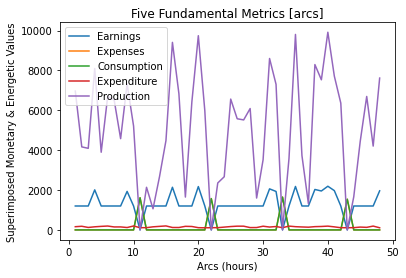

In [826]:

#######################################################################################
# Fundamental Metrics FIRST 48
#######################################################################################
fig_title = 'Five Fundamental Metrics'
fig_resolution = 'arcs' # revolutions OR arcs
fig_a, ax_a = plt.subplots()
ax_a.set_title(f'{fig_title} [{fig_resolution}]')
ax_a.set_xlabel('Arcs (hours)')
ax_a.set_ylabel('Superimposed Monetary & Energetic Values')

st = None #start
sp = 48 #stop
sk = None #skip


ax_a.plot(X_arcs[st:sp:sk],
          me.earnings[st:sp:sk],
          label='Earnings')

ax_a.plot(X_arcs[st:sp:sk],
          me.expenses[st:sp:sk],
          label='Expenses')

ax_a.plot(X_arcs[st:sp:sk],
          me.consumption[st:sp:sk],
          label='Consumption')

ax_a.plot(X_arcs[st:sp:sk],
          me.expenditure[st:sp:sk],
          label='Expenditure')

ax_a.plot(X_arcs[st:sp:sk],
          me.production[st:sp:sk],
          label='Production')


ax_a.legend()


pdf_path, csv_path = pdir.generate_save_directories(fig_title, f'{sp} {fig_resolution}')
fig_a.savefig(pdf_path)

csv_headers = X_arcs[st:sp:sk]
csv_values = [
    me.earnings[st:sp:sk],
    me.expenses[st:sp:sk],
    me.consumption[st:sp:sk],
    me.expenditure[st:sp:sk],
    me.production[st:sp:sk]
]

with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(csv_headers)
    writer.writerows(csv_values)


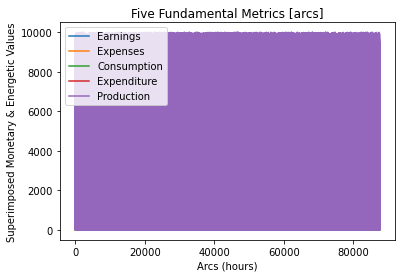

In [827]:

#######################################################################################
# Fundamental Metrics
#######################################################################################
fig_title = 'Five Fundamental Metrics'
fig_resolution = 'arcs' # revolutions OR arcs
fig_a, ax_a = plt.subplots()
ax_a.set_title(f'{fig_title} [{fig_resolution}]')
ax_a.set_xlabel('Arcs (hours)')
ax_a.set_ylabel('Superimposed Monetary & Energetic Values')

st = None #start
sp = None #stop
sk = None #skip


ax_a.plot(X_arcs[st:sp:sk],
          me.earnings[st:sp:sk],
          label='Earnings')

ax_a.plot(X_arcs[st:sp:sk],
          me.expenses[st:sp:sk],
          label='Expenses')

ax_a.plot(X_arcs[st:sp:sk],
          me.consumption[st:sp:sk],
          label='Consumption')

ax_a.plot(X_arcs[st:sp:sk],
          me.expenditure[st:sp:sk],
          label='Expenditure')

ax_a.plot(X_arcs[st:sp:sk],
          me.production[st:sp:sk],
          label='Production')


ax_a.legend()


pdf_path, csv_path = pdir.generate_save_directories(fig_title, f'{sp} {fig_resolution}')
fig_a.savefig(pdf_path)

csv_headers = X_arcs[st:sp:sk]
csv_values = [
    me.earnings[st:sp:sk],
    me.expenses[st:sp:sk],
    me.consumption[st:sp:sk],
    me.expenditure[st:sp:sk],
    me.production[st:sp:sk]
]

with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(csv_headers)
    writer.writerows(csv_values)


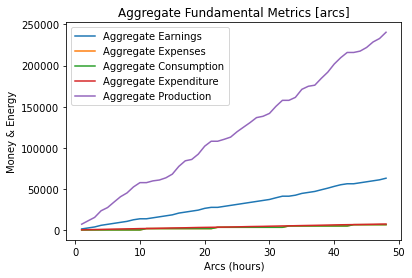

In [828]:

#######################################################################################
# Aggregate Fundamental Metrics FIRST 48
#######################################################################################
fig_title = 'Aggregate Fundamental Metrics'
fig_resolution = 'arcs' # revolutions OR arcs
fig_a, ax_a = plt.subplots()
ax_a.set_title(f'{fig_title} [{fig_resolution}]')
ax_a.set_xlabel('Arcs (hours)')
ax_a.set_ylabel('Money & Energy')

st = None #start
sp = 48 #stop
sk = None #skip


ax_a.plot(X_arcs[st:sp:sk],
          me.agg_earnings[st:sp:sk],
          label='Aggregate Earnings')

ax_a.plot(X_arcs[st:sp:sk],
          me.agg_expenses[st:sp:sk],
          label='Aggregate Expenses')

ax_a.plot(X_arcs[st:sp:sk],
          me.agg_consumption[st:sp:sk],
          label='Aggregate Consumption')

ax_a.plot(X_arcs[st:sp:sk],
          me.agg_expenditure[st:sp:sk],
          label='Aggregate Expenditure')

ax_a.plot(X_arcs[st:sp:sk],
          me.agg_production[st:sp:sk],
          label='Aggregate Production')


ax_a.legend()


pdf_path, csv_path = pdir.generate_save_directories(fig_title, f'{sp} {fig_resolution}')
fig_a.savefig(pdf_path)

csv_headers = X_arcs[st:sp:sk]

csv_values = [
    me.agg_earnings[st:sp:sk],
    me.agg_expenses[st:sp:sk],
    me.agg_consumption[st:sp:sk],
    me.agg_expenditure[st:sp:sk],
    me.agg_production[st:sp:sk],
]
with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(csv_headers)
    writer.writerows(csv_values)


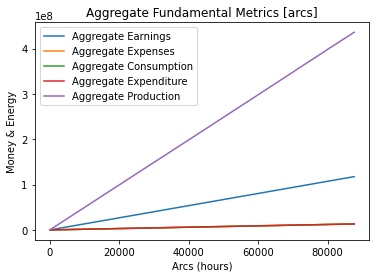

In [829]:

#######################################################################################
# Aggregate Fundamental Metrics
#######################################################################################
fig_title = 'Aggregate Fundamental Metrics'
fig_resolution = 'arcs' # revolutions OR arcs
fig_a, ax_a = plt.subplots()
ax_a.set_title(f'{fig_title} [{fig_resolution}]')
ax_a.set_xlabel('Arcs (hours)')
ax_a.set_ylabel('Money & Energy')

st = None #start
sp = None #stop
sk = None #skip


ax_a.plot(X_arcs[st:sp:sk],
          me.agg_earnings[st:sp:sk],
          label='Aggregate Earnings')

ax_a.plot(X_arcs[st:sp:sk],
          me.agg_expenses[st:sp:sk],
          label='Aggregate Expenses')

ax_a.plot(X_arcs[st:sp:sk],
          me.agg_consumption[st:sp:sk],
          label='Aggregate Consumption')

ax_a.plot(X_arcs[st:sp:sk],
          me.agg_expenditure[st:sp:sk],
          label='Aggregate Expenditure')

ax_a.plot(X_arcs[st:sp:sk],
          me.agg_production[st:sp:sk],
          label='Aggregate Production')


ax_a.legend()


pdf_path, csv_path = pdir.generate_save_directories(fig_title, f'{sp} {fig_resolution}')
fig_a.savefig(pdf_path)

csv_headers = X_arcs[st:sp:sk]

csv_values = [
    me.agg_earnings[st:sp:sk],
    me.agg_expenses[st:sp:sk],
    me.agg_consumption[st:sp:sk],
    me.agg_expenditure[st:sp:sk],
    me.agg_production[st:sp:sk],
]
with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(csv_headers)
    writer.writerows(csv_values)


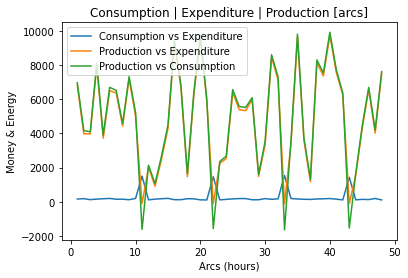

In [830]:

#######################################################################################
# Consumption | Expenditure | Production FIRST 48
#######################################################################################
fig_title = 'Consumption | Expenditure | Production'
fig_resolution = 'arcs' # revolutions OR arcs
fig_a, ax_a = plt.subplots()
ax_a.set_title(f'{fig_title} [{fig_resolution}]')
ax_a.set_xlabel('Arcs (hours)')
ax_a.set_ylabel('Money & Energy')

st = None #start
sp = 48 #stop
sk = None #skip


ax_a.plot(X_arcs[st:sp:sk],
          me.consumption_vs_expenditure[st:sp:sk],
          label='Consumption vs Expenditure')

ax_a.plot(X_arcs[st:sp:sk],
          me.production_vs_expenditure[st:sp:sk],
          label='Production vs Expenditure')

ax_a.plot(X_arcs[st:sp:sk],
          me.production_vs_consumption[st:sp:sk],
          label='Production vs Consumption')


ax_a.legend()


pdf_path, csv_path = pdir.generate_save_directories(fig_title, f'{sp} {fig_resolution}')
fig_a.savefig(pdf_path)

csv_headers = X_arcs[st:sp:sk]

csv_values = [
    me.consumption_vs_expenditure[st:sp:sk],
    me.production_vs_expenditure[st:sp:sk],
    me.production_vs_consumption[st:sp:sk]
]
with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(csv_headers)
    writer.writerows(csv_values)


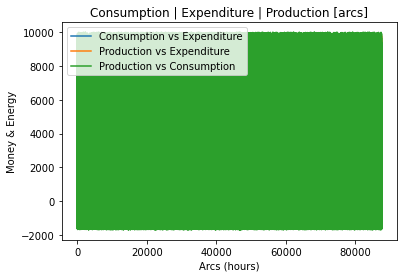

In [831]:

#######################################################################################
# Consumption | Expenditure | Production FIRST 48
#######################################################################################
fig_title = 'Consumption | Expenditure | Production'
fig_resolution = 'arcs' # revolutions OR arcs
fig_a, ax_a = plt.subplots()
ax_a.set_title(f'{fig_title} [{fig_resolution}]')
ax_a.set_xlabel('Arcs (hours)')
ax_a.set_ylabel('Money & Energy')

st = None #start
sp = None #stop
sk = None #skip


ax_a.plot(X_arcs[st:sp:sk],
          me.consumption_vs_expenditure[st:sp:sk],
          label='Consumption vs Expenditure')

ax_a.plot(X_arcs[st:sp:sk],
          me.production_vs_expenditure[st:sp:sk],
          label='Production vs Expenditure')

ax_a.plot(X_arcs[st:sp:sk],
          me.production_vs_consumption[st:sp:sk],
          label='Production vs Consumption')


ax_a.legend()


pdf_path, csv_path = pdir.generate_save_directories(fig_title, f'{sp} {fig_resolution}')
fig_a.savefig(pdf_path)

csv_headers = X_arcs[st:sp:sk]

csv_values = [
    me.consumption_vs_expenditure[st:sp:sk],
    me.production_vs_expenditure[st:sp:sk],
    me.production_vs_consumption[st:sp:sk]
]
with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(csv_headers)
    writer.writerows(csv_values)


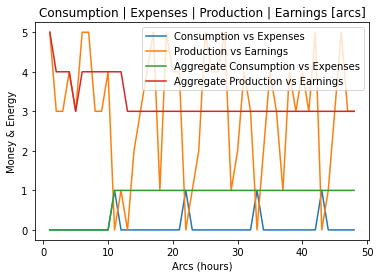

In [832]:

#######################################################################################
# Consumption | Expenses | Production | Earnings FIRST 48
#######################################################################################
fig_title = 'Consumption | Expenses | Production | Earnings'
fig_resolution = 'arcs' # revolutions OR arcs
fig_a, ax_a = plt.subplots()
ax_a.set_title(f'{fig_title} [{fig_resolution}]')
ax_a.set_xlabel('Arcs (hours)')
ax_a.set_ylabel('Money & Energy')

st = None #start
sp = 48 #stop
sk = None #skip


ax_a.plot(X_arcs[st:sp:sk],
          me.consumption_vs_expenses[st:sp:sk],
          label='Consumption vs Expenses')

ax_a.plot(X_arcs[st:sp:sk],
          me.production_vs_earnings[st:sp:sk],
          label='Production vs Earnings')

ax_a.plot(X_arcs[st:sp:sk],
          me.agg_consumption_vs_expenses[st:sp:sk],
          label='Aggregate Consumption vs Expenses')

ax_a.plot(X_arcs[st:sp:sk],
          me.agg_production_vs_earnings[st:sp:sk],
          label='Aggregate Production vs Earnings')


ax_a.legend()


pdf_path, csv_path = pdir.generate_save_directories(fig_title, fig_resolution)
fig_a.savefig(pdf_path)

csv_headers = X_arcs[st:sp:sk]

csv_values = [
    me.consumption_vs_expenses[st:sp:sk],
    me.production_vs_earnings[st:sp:sk],
    me.agg_consumption_vs_expenses[st:sp:sk],
    me.agg_production_vs_earnings[st:sp:sk]
]
with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(csv_headers)
    writer.writerows(csv_values)


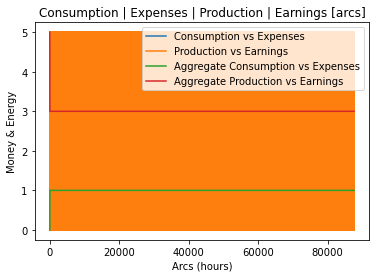

In [833]:

#######################################################################################
# Consumption | Expenses | Production | Earnings
#######################################################################################
fig_title = 'Consumption | Expenses | Production | Earnings'
fig_resolution = 'arcs' # revolutions OR arcs
fig_a, ax_a = plt.subplots()
ax_a.set_title(f'{fig_title} [{fig_resolution}]')
ax_a.set_xlabel('Arcs (hours)')
ax_a.set_ylabel('Money & Energy')

st = None #start
sp = None #stop
sk = None #skip


ax_a.plot(X_arcs[st:sp:sk],
          me.consumption_vs_expenses[st:sp:sk],
          label='Consumption vs Expenses')

ax_a.plot(X_arcs[st:sp:sk],
          me.production_vs_earnings[st:sp:sk],
          label='Production vs Earnings')

ax_a.plot(X_arcs[st:sp:sk],
          me.agg_consumption_vs_expenses[st:sp:sk],
          label='Aggregate Consumption vs Expenses')

ax_a.plot(X_arcs[st:sp:sk],
          me.agg_production_vs_earnings[st:sp:sk],
          label='Aggregate Production vs Earnings')


ax_a.legend()


pdf_path, csv_path = pdir.generate_save_directories(fig_title, fig_resolution)
fig_a.savefig(pdf_path)

csv_headers = X_arcs[st:sp:sk]

csv_values = [
    me.consumption_vs_expenses[st:sp:sk],
    me.production_vs_earnings[st:sp:sk],
    me.agg_consumption_vs_expenses[st:sp:sk],
    me.agg_production_vs_earnings[st:sp:sk]
]
with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(csv_headers)
    writer.writerows(csv_values)


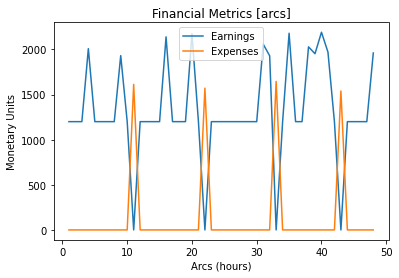

In [834]:

#######################################################################################
# Financial Metrics FIRST 48
#######################################################################################
fig_title = 'Financial Metrics'
fig_resolution = 'arcs' # revolutions OR arcs
fig_a, ax_a = plt.subplots()
ax_a.set_title(f'{fig_title} [{fig_resolution}]')
ax_a.set_xlabel('Arcs (hours)')
ax_a.set_ylabel('Monetary Units')

st = None #start
sp = 48 #stop
sk = None #skip


ax_a.plot(X_arcs[st:sp:sk],
          me.earnings[st:sp:sk],
          label='Earnings')

ax_a.plot(X_arcs[st:sp:sk],
          me.expenses[st:sp:sk],
          label='Expenses')


ax_a.legend()


pdf_path, csv_path = pdir.generate_save_directories(fig_title, f'{sp} {fig_resolution}')
fig_a.savefig(pdf_path)

csv_headers = X_arcs[st:sp:sk]
csv_values = [
    me.earnings[st:sp:sk],
    me.expenses[st:sp:sk]
]

with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(csv_headers)
    writer.writerows(csv_values)


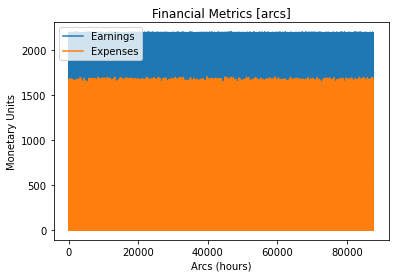

In [835]:

#######################################################################################
# Financial Metrics
#######################################################################################
fig_title = 'Financial Metrics'
fig_resolution = 'arcs' # revolutions OR arcs
fig_a, ax_a = plt.subplots()
ax_a.set_title(f'{fig_title} [{fig_resolution}]')
ax_a.set_xlabel('Arcs (hours)')
ax_a.set_ylabel('Monetary Units')

st = None #start
sp = None #stop
sk = None #skip


ax_a.plot(X_arcs[st:sp:sk],
          me.earnings[st:sp:sk],
          label='Earnings')

ax_a.plot(X_arcs[st:sp:sk],
          me.expenses[st:sp:sk],
          label='Expenses')


ax_a.legend()


pdf_path, csv_path = pdir.generate_save_directories(fig_title, f'{sp} {fig_resolution}')
fig_a.savefig(pdf_path)

csv_headers = X_arcs[st:sp:sk]
csv_values = [
    me.earnings[st:sp:sk],
    me.expenses[st:sp:sk]
]

with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(csv_headers)
    writer.writerows(csv_values)


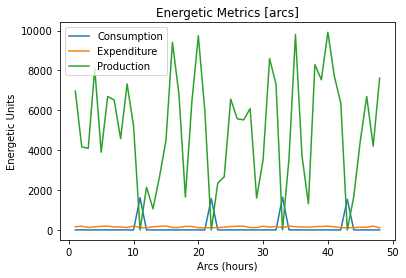

In [836]:

#######################################################################################
# Energetic Metrics FIRST 48
#######################################################################################
fig_title = 'Energetic Metrics'
fig_resolution = 'arcs' # revolutions OR arcs
fig_a, ax_a = plt.subplots()
ax_a.set_title(f'{fig_title} [{fig_resolution}]')
ax_a.set_xlabel('Arcs (hours)')
ax_a.set_ylabel('Energetic Units')

st = None #start
sp = 48 #stop
sk = None #skip


ax_a.plot(X_arcs[st:sp:sk],
          me.consumption[st:sp:sk],
          label='Consumption')

ax_a.plot(X_arcs[st:sp:sk],
          me.expenditure[st:sp:sk],
          label='Expenditure')

ax_a.plot(X_arcs[st:sp:sk],
          me.production[st:sp:sk],
          label='Production')


ax_a.legend()


pdf_path, csv_path = pdir.generate_save_directories(fig_title, f'{sp} {fig_resolution}')
fig_a.savefig(pdf_path)

csv_headers = X_arcs[st:sp:sk]
csv_values = [
    me.consumption[st:sp:sk],
    me.expenditure[st:sp:sk],
    me.production[st:sp:sk]
]

with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(csv_headers)
    writer.writerows(csv_values)


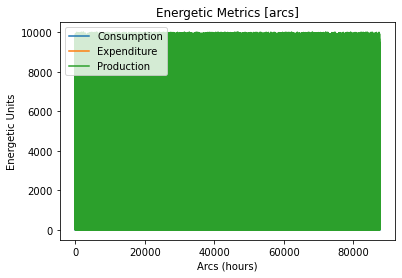

In [837]:

#######################################################################################
# Energetic Metrics
#######################################################################################
fig_title = 'Energetic Metrics'
fig_resolution = 'arcs' # revolutions OR arcs
fig_a, ax_a = plt.subplots()
ax_a.set_title(f'{fig_title} [{fig_resolution}]')
ax_a.set_xlabel('Arcs (hours)')
ax_a.set_ylabel('Energetic Units')

st = None #start
sp = None #stop
sk = None #skip


ax_a.plot(X_arcs[st:sp:sk],
          me.consumption[st:sp:sk],
          label='Consumption')

ax_a.plot(X_arcs[st:sp:sk],
          me.expenditure[st:sp:sk],
          label='Expenditure')

ax_a.plot(X_arcs[st:sp:sk],
          me.production[st:sp:sk],
          label='Production')


ax_a.legend()


pdf_path, csv_path = pdir.generate_save_directories(fig_title, f'{sp} {fig_resolution}')
fig_a.savefig(pdf_path)

csv_headers = X_arcs[st:sp:sk]
csv_values = [
    me.consumption[st:sp:sk],
    me.expenditure[st:sp:sk],
    me.production[st:sp:sk]
]

with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(csv_headers)
    writer.writerows(csv_values)


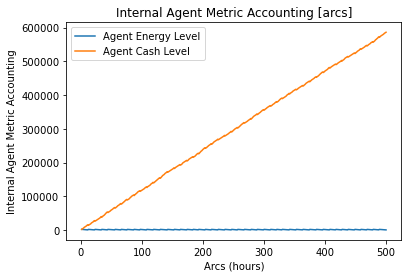

In [838]:

#######################################################################################
# Internal Agent Metric Accounting FIRST 500
#######################################################################################
fig_title = 'Internal Agent Metric Accounting'
fig_resolution = 'arcs' # revolutions OR arcs
fig_a, ax_a = plt.subplots()
ax_a.set_title(f'{fig_title} [{fig_resolution}]')
ax_a.set_xlabel('Arcs (hours)')
ax_a.set_ylabel('Internal Agent Metric Accounting')

st = None #start
sp = 500 #stop
sk = None #skip


ax_a.plot(X_arcs[st:sp:sk],
          me.energy_level[st:sp:sk],
          label='Agent Energy Level')

ax_a.plot(X_arcs[st:sp:sk],
          me.cash_level[st:sp:sk],
          label='Agent Cash Level')


ax_a.legend()


pdf_path, csv_path = pdir.generate_save_directories(fig_title, f'{sp} {fig_resolution}')
fig_a.savefig(pdf_path)

csv_headers = X_arcs[st:sp:sk]
csv_values = [
    me.energy_level[st:sp:sk],
    me.cash_level[st:sp:sk]
]

with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(csv_headers)
    writer.writerows(csv_values)


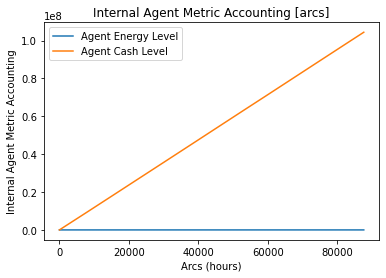

In [839]:

#######################################################################################
# Internal Agent Metric Accounting
#######################################################################################
fig_title = 'Internal Agent Metric Accounting'
fig_resolution = 'arcs' # revolutions OR arcs
fig_a, ax_a = plt.subplots()
ax_a.set_title(f'{fig_title} [{fig_resolution}]')
ax_a.set_xlabel('Arcs (hours)')
ax_a.set_ylabel('Internal Agent Metric Accounting')

st = None #start
sp = None #stop
sk = None #skip


ax_a.plot(X_arcs[st:sp:sk],
          me.energy_level[st:sp:sk],
          label='Agent Energy Level')

ax_a.plot(X_arcs[st:sp:sk],
          me.cash_level[st:sp:sk],
          label='Agent Cash Level')


ax_a.legend()


pdf_path, csv_path = pdir.generate_save_directories(fig_title, f'{sp} {fig_resolution}')
fig_a.savefig(pdf_path)

csv_headers = X_arcs[st:sp:sk]
csv_values = [
    me.energy_level[st:sp:sk],
    me.cash_level[st:sp:sk]
]

with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(csv_headers)
    writer.writerows(csv_values)


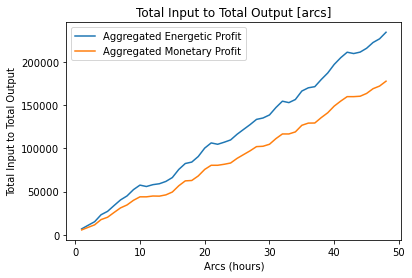

In [840]:

#######################################################################################
# Total Input to Total Output FIRST 48
#######################################################################################
fig_title = 'Total Input to Total Output'
fig_resolution = 'arcs' # revolutions OR arcs
fig_a, ax_a = plt.subplots()
ax_a.set_title(f'{fig_title} [{fig_resolution}]')
ax_a.set_xlabel('Arcs (hours)')
ax_a.set_ylabel('Total Input to Total Output')

st = None #start
sp = 48 #stop
sk = None #skip


agg_energetic_profit    = list()
agg_monetary_profit     = list()

for i in range(len(X_arcs)):

    # energetic output to input difference
    agg_energetic_profit.append(me.agg_production[i] - me.agg_consumption[i])

    # monetary output to input difference
    agg_monetary_profit.append((m2e*me.agg_production[i]) - me.agg_earnings[i])


# there is a gap where extra money is charged for a product
# by the company - but there is also a gap where extra output is
# given to the boss because of this - so they get two hits.
# 1. by taking the worker's work
# 2. by selling it for even more than what was already made off it.

ax_a.plot(X_arcs[st:sp:sk],
          agg_energetic_profit[st:sp:sk],
          label='Aggregated Energetic Profit')

ax_a.plot(X_arcs[st:sp:sk],
          agg_monetary_profit[st:sp:sk],
          label='Aggregated Monetary Profit')


ax_a.legend()


pdf_path, csv_path = pdir.generate_save_directories(fig_title, f'{sp} {fig_resolution}')
fig_a.savefig(pdf_path)

csv_headers = X_arcs[st:sp:sk]
csv_values = [
    agg_energetic_profit[st:sp:sk],
    agg_monetary_profit[st:sp:sk]
]

with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(csv_headers)
    writer.writerows(csv_values)


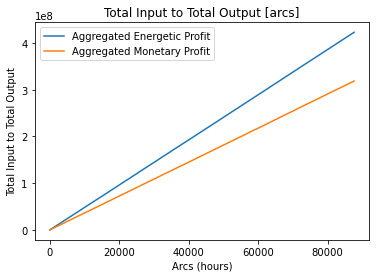

In [841]:

#######################################################################################
# Total Input to Total Output
#######################################################################################
fig_title = 'Total Input to Total Output'
fig_resolution = 'arcs' # revolutions OR arcs
fig_a, ax_a = plt.subplots()
ax_a.set_title(f'{fig_title} [{fig_resolution}]')
ax_a.set_xlabel('Arcs (hours)')
ax_a.set_ylabel('Total Input to Total Output')

st = None #start
sp = None #stop
sk = None #skip


agg_energetic_profit    = list()
agg_monetary_profit     = list()

for i in range(len(X_arcs)):

    # energetic output to input difference
    agg_energetic_profit.append(me.agg_production[i] - me.agg_consumption[i])

    # monetary output to input difference
    agg_monetary_profit.append((m2e*me.agg_production[i]) - me.agg_earnings[i])


# there is a gap where extra money is charged for a product
# by the company - but there is also a gap where extra output is
# given to the boss because of this - so they get two hits.
# 1. by taking the worker's work
# 2. by selling it for even more than what was already made off it.

ax_a.plot(X_arcs[st:sp:sk],
          agg_energetic_profit[st:sp:sk],
          label='Aggregated Energetic Profit')

ax_a.plot(X_arcs[st:sp:sk],
          agg_monetary_profit[st:sp:sk],
          label='Aggregated Monetary Profit')


ax_a.legend()


pdf_path, csv_path = pdir.generate_save_directories(fig_title, f'{sp} {fig_resolution}')
fig_a.savefig(pdf_path)

csv_headers = X_arcs[st:sp:sk]
csv_values = [
    agg_energetic_profit[st:sp:sk],
    agg_monetary_profit[st:sp:sk]
]

with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(csv_headers)
    writer.writerows(csv_values)


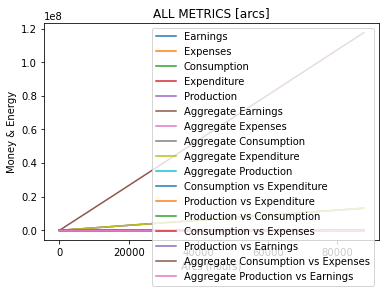

In [842]:

#######################################################################################
# ALL METRICS [NOT REALLY FOR GRAPHICAL SHOW]
#######################################################################################
fig_title = 'ALL METRICS'
fig_resolution = 'arcs' # revolutions OR arcs
fig_a, ax_a = plt.subplots()
ax_a.set_title(f'{fig_title} [{fig_resolution}]')
ax_a.set_xlabel('Arcs (hours)')
ax_a.set_ylabel('Money & Energy')

st = None #start
sp = None #stop
sk = None #skip

ax_a.plot(X_arcs[st:sp:sk],
          me.earnings[st:sp:sk],
          label='Earnings')

ax_a.plot(X_arcs[st:sp:sk],
          me.expenses[st:sp:sk],
          label='Expenses')

ax_a.plot(X_arcs[st:sp:sk],
          me.consumption[st:sp:sk],
          label='Consumption')

ax_a.plot(X_arcs[st:sp:sk],
          me.expenditure[st:sp:sk],
          label='Expenditure')

ax_a.plot(X_arcs[st:sp:sk],
          me.production[st:sp:sk],
          label='Production')



ax_a.plot(X_arcs[st:sp:sk],
          me.agg_earnings[st:sp:sk],
          label='Aggregate Earnings')

ax_a.plot(X_arcs[st:sp:sk],
          me.agg_expenses[st:sp:sk],
          label='Aggregate Expenses')

ax_a.plot(X_arcs[st:sp:sk],
          me.agg_consumption[st:sp:sk],
          label='Aggregate Consumption')

ax_a.plot(X_arcs[st:sp:sk],
          me.agg_expenditure[st:sp:sk],
          label='Aggregate Expenditure')

ax_a.plot(X_arcs[st:sp:sk],
          me.production[st:sp:sk],
          label='Aggregate Production')



ax_a.plot(X_arcs[st:sp:sk],
          me.consumption_vs_expenditure[st:sp:sk],
          label='Consumption vs Expenditure')

ax_a.plot(X_arcs[st:sp:sk],
          me.production_vs_expenditure[st:sp:sk],
          label='Production vs Expenditure')

ax_a.plot(X_arcs[st:sp:sk],
          me.production_vs_consumption[st:sp:sk],
          label='Production vs Consumption')



ax_a.plot(X_arcs[st:sp:sk],
          me.consumption_vs_expenses[st:sp:sk],
          label='Consumption vs Expenses')

ax_a.plot(X_arcs[st:sp:sk],
          me.production_vs_earnings[st:sp:sk],
          label='Production vs Earnings')

ax_a.plot(X_arcs[st:sp:sk],
          me.agg_consumption_vs_expenses[st:sp:sk],
          label='Aggregate Consumption vs Expenses')

ax_a.plot(X_arcs[st:sp:sk],
          me.agg_production_vs_earnings[st:sp:sk],
          label='Aggregate Production vs Earnings')


ax_a.legend()


pdf_path, csv_path = pdir.generate_save_directories(fig_title, fig_resolution)
fig_a.savefig(pdf_path)

csv_headers = X_arcs[st:sp:sk]

csv_values = [
    me.earnings[st:sp:sk],
    me.expenses[st:sp:sk],
    me.consumption[st:sp:sk],
    me.expenditure[st:sp:sk],
    me.production[st:sp:sk],

    me.agg_earnings[st:sp:sk],
    me.agg_expenses[st:sp:sk],
    me.agg_consumption[st:sp:sk],
    me.agg_expenditure[st:sp:sk],
    me.agg_production[st:sp:sk],

    me.consumption_vs_expenditure[st:sp:sk],
    me.production_vs_expenditure[st:sp:sk],
    me.production_vs_consumption[st:sp:sk],

    me.consumption_vs_expenses[st:sp:sk],
    me.production_vs_earnings[st:sp:sk],
    me.agg_consumption_vs_expenses[st:sp:sk],
    me.agg_production_vs_earnings[st:sp:sk]
]
with open(csv_path, 'w', newline='') as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(csv_headers)
    writer.writerows(csv_values)
